In [1]:
%load_ext watermark


In [2]:
from Bio import Phylo as BioPhylo
import alifedata_phyloinformatics_convert as apc
import covasim as cv
from hstrat import _auxiliary_lib as hstrat_aux
from matplotlib import patches as mpl_patches
from matplotlib import pyplot as plt
import numpy as np
from teeplot import teeplot as tp

from pylib._cv_infection_log_to_alstd_df import cv_infection_log_to_alstd_df
from pylib._pairplot import pairplot


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-04-09T13:19:45.179448+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot                           : 1.4.2
matplotlib                        : 3.9.2
covasim                           : 3.1.6
numpy                             : 2.1.2
hstrat                            : 1.19.6
alifedata_phyloinformatics_convert: 0.19.3
Bio                               : 1.85

Watermark: 2.4.3



In [4]:
teeplot_subdir = "2025-04-07-dev-variantscreen"
teeplot_subdir


'2025-04-07-dev-variantscreen'

## Setup Params

Define `gamma` and `delta` strains, as well as accompanying lower-transmissibility `gamma'` and `delta'` strains.


In [5]:
pop_size = 10_000
num_variants = 5  # 0th variant is wild-type


In [6]:
# from https://github.com/InstituteforDiseaseModeling/covasim/blob/fef033fed5a0ca71be9c4f773d75dce1d237e753/covasim/parameters.py
gamma = dict(
    rel_beta=2.05,  # Estimated to be 1.7-2.4-fold more transmissible than wild-type: https://science.sciencemag.org/content/early/2021/04/13/science.abh2644
    rel_symp_prob=1.0,
    rel_severe_prob=2.6,  # From https://www.eurosurveillance.org/content/10.2807/1560-7917.ES.2021.26.16.2100348
    rel_crit_prob=1.0,
    rel_death_prob=1.0,
)
gamma_ = {**gamma, "rel_beta": 1.5}  # lower-transmissibility variant

delta = dict(
    rel_beta=2.2,  # Estimated to be 1.25-1.6-fold more transmissible than B117: https://www.researchsquare.com/article/rs-637724/v1
    rel_symp_prob=1.0,
    rel_severe_prob=3.2,  # 2x more transmissible than alpha from https://mobile.twitter.com/dgurdasani1/status/1403293582279294983
    rel_crit_prob=1.0,
    rel_death_prob=1.0,
)
delta_ = {**delta, "rel_beta": 1.6}  # lower-transmissibility variant


In [7]:
# import gamma and then delta 30 days later
gamma = cv.variant(variant=gamma, label="gamma", days=0, n_imports=10)
delta = cv.variant(variant=delta, label="delta", days=30, n_imports=100)

# lower-transimissibility variants arise from spontaneous mutations, not imports
gamma_ = cv.variant(variant=gamma_, label="gamma'", days=0, n_imports=0)
delta_ = cv.variant(variant=delta_, label="delta'", days=0, n_imports=0)


## Prototype Within-host Dynamics Extension


In [8]:
class SyncWithinHost:

    _host_compartments: np.ndarray

    def __init__(
        self: "SyncWithinHost", pop_size: int, num_variants: int
    ) -> None:
        shape = (pop_size, num_variants)
        self._host_compartments = np.zeros(shape, dtype=float)

    def __call__(self: "SyncWithinHost", sim: cv.Sim) -> None:
        compartments = self._host_compartments
        people = sim.people
        random_p = np.random.rand(*people["infectious_variant"].shape)

        ## sync covasim to host compartments
        #######################################################################
        # zero out non-infectious/exposed compartments
        mask = ~(people["infectious"] | people["exposed"])
        compartments[mask, :] = 0.0

        # ensure host compartments are initialized w/ covasim infectious variant
        for variant in range(1, num_variants):
            compartments[:, variant] = np.maximum(
                people["infectious_variant"] == variant,
                compartments[:, variant],
            )

        # update host compartments
        #######################################################################
        # grow strains
        compartments[:, 1] *= 2.0
        compartments[:, 2] *= 3.0  # lower-trans variant, faster growth
        compartments[:, 3] *= 2.0
        compartments[:, 4] *= 3.0  # lower-trans variant, faster growth

        # introduce low-transmissibility variants thru spontaneous mutation
        # of high-transmissibility variants
        # e.g., gamma -> gamma' and delta -> delta'
        for lowtran_variant in 2, 4:
            p = 1.0 - np.power(0.95, compartments[:, lowtran_variant - 1])
            compartments[:, lowtran_variant] = np.maximum(
                random_p < p,
                compartments[:, lowtran_variant],
            )

        ## sync host compartments to covasim "infectious variant"
        #######################################################################
        # sample current infectious variant from compartments
        compartments_ = compartments.copy()
        compartments_ *= np.random.rand(*compartments.shape)
        compartments_[1, :] *= 1.5  # higher-transmissiblity bonus
        compartments_[3, :] *= 1.5  # higher-transmissiblity bonus
        sampled_strains = np.where(
            compartments_.any(axis=1),
            np.argmax(compartments_, axis=1),
            np.nan,
        )

        # update current covasim infectious variant
        people["infectious_variant"] = np.where(
            ~np.isnan(people["infectious_variant"]),
            sampled_strains,
            people["infectious_variant"],
        )


## Run Example Simulation


In [9]:
sim = cv.Sim(
    interventions=[SyncWithinHost(pop_size, num_variants)],
    pop_infected=0,  # disable wild-type strain
    pop_size=pop_size,
    variants=[gamma, gamma_, delta, delta_],
    rand_seed=1,
)
sim.run()


Initializing sim with 10000 people for 60 days
  Running 2020-03-01 ( 0/60) (0.09 s)  ———————————————————— 2%
  Running 2020-03-11 (10/60) (0.14 s)  •••————————————————— 18%
  Running 2020-03-21 (20/60) (0.19 s)  ••••••—————————————— 34%
  Running 2020-03-31 (30/60) (0.24 s)  ••••••••••—————————— 51%
  Running 2020-04-10 (40/60) (0.33 s)  •••••••••••••——————— 67%
  Running 2020-04-20 (50/60) (0.43 s)  ••••••••••••••••———— 84%
  Running 2020-04-30 (60/60) (0.53 s)  •••••••••••••••••••• 100%

Simulation summary:
       12,184 cumulative infections
        2,503 cumulative reinfections
       11,804 cumulative infectious
        7,493 cumulative symptomatic cases
        1,398 cumulative severe cases
          433 cumulative critical cases
        9,585 cumulative recoveries
          104 cumulative deaths
            0 cumulative tests
            0 cumulative diagnoses
            0 cumulative known deaths
            0 cumulative quarantined people
            0 cumulative isolated peo

Sim(<no label>; 2020-03-01 to 2020-04-30; pop: 10000 random; epi: 12184⚙, 104☠)

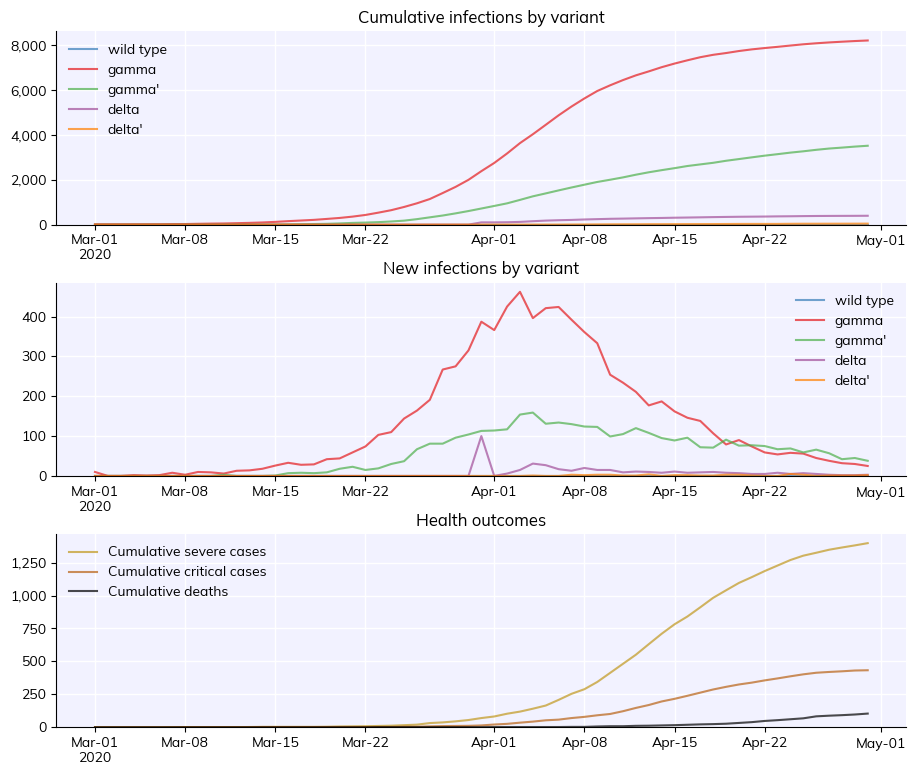

teeplots/2025-04-07-dev-variantscreen/viz=plot+what=within-host+ext=.pdf
teeplots/2025-04-07-dev-variantscreen/viz=plot+what=within-host+ext=.png


<Figure size 640x480 with 0 Axes>

Ellipsis

In [10]:
tp.tee(
    sim.plot,
    "variant",
    teeplot_outattrs={"what": "within-host"},
    teeplot_subdir=teeplot_subdir,
)
...


## Visualize Pathogen Phylogeny


In [11]:
phylo_df = cv_infection_log_to_alstd_df(sim.people.infection_log)

phylo_df = hstrat_aux.alifestd_downsample_tips_asexual(
    phylo_df, n_downsample=200
)

phylo_tree = apc.alife_dataframe_to_biopython_tree(
    phylo_df,
    setattrs=["variant"],
    setup_branch_lengths=True,
)

node_colors = {
    "delta": "blue",
    "delta'": "green",
    "gamma": "red",
    "gamma'": "purple",
}
for node in phylo_tree.find_clades():
    node.color = node_colors[node.variant]


2025-04-07-dev-variantscreen/viz=draw-biophylo+what=within-host+ext=.pdf
2025-04-07-dev-variantscreen/viz=draw-biophylo+what=within-host+ext=.png


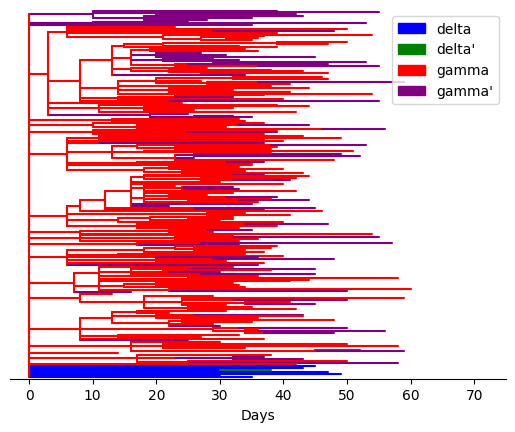

In [12]:
def draw_biophylo(tree: BioPhylo.BaseTree, **kwargs) -> plt.Axes:
    ax = plt.gca()
    BioPhylo.draw(tree, axes=ax, do_show=False, **kwargs)
    return ax


with tp.teed(
    draw_biophylo,
    phylo_tree,
    teeplot_outattrs={"what": "within-host"},
    teeplot_outdir=teeplot_subdir,
) as ax:
    ax.set_xlabel("Days")
    ax.yaxis.set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    legend_handles = [
        mpl_patches.Patch(color=color, label=variant)
        for variant, color in node_colors.items()
    ]
    ax.legend(handles=legend_handles, loc="upper right")


## Process Pathogen Phylogeny


In [13]:
phylo_df = cv_infection_log_to_alstd_df(sim.people.infection_log)


In [14]:
# clean tree topology
phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)
phylo_df = hstrat_aux.alifestd_add_inner_leaves(phylo_df, mutate=True)
phylo_df = hstrat_aux.alifestd_splay_polytomies(phylo_df, mutate=True)
phylo_df = hstrat_aux.alifestd_collapse_unifurcations(phylo_df, mutate=True)
phylo_df = hstrat_aux.alifestd_delete_unifurcating_roots_asexual(
    phylo_df, mutate=True
)
phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)


In [15]:
# sister statistics
with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_duration_ratio_sister_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_mark_clade_duration_ratio_sister_asexual(
        phylo_df, mutate=True
    )

with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_logistic_growth_sister_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_mark_clade_logistic_growth_sister_asexual(
        phylo_df, mutate=True
    )

with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_leafcount_ratio_sister_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_mark_clade_leafcount_ratio_sister_asexual(
        phylo_df, mutate=True
    )


enter log_context_duration for alifestd_mark_clade_duration_ratio_sister_asexual


/usr/local/lib/python3.10/dist-packages/hstrat/_auxiliary_lib/_alifestd_mark_clade_duration_ratio_sister_asexual.py:51: RuntimeWarning: divide by zero encountered in divide
  phylogeny_df["clade_duration_ratio_sister"] = (
/usr/local/lib/python3.10/dist-packages/hstrat/_auxiliary_lib/_alifestd_mark_clade_duration_ratio_sister_asexual.py:51: RuntimeWarning: invalid value encountered in divide
  phylogeny_df["clade_duration_ratio_sister"] = (


exit log_context_duration for alifestd_mark_clade_duration_ratio_sister_asexual
!!! {"alifestd_mark_clade_duration_ratio_sister_asexual": 3.522449254989624}
enter log_context_duration for alifestd_mark_clade_logistic_growth_sister_asexual


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


exit log_context_duration for alifestd_mark_clade_logistic_growth_sister_asexual
!!! {"alifestd_mark_clade_logistic_growth_sister_asexual": 14.553088903427124}
enter log_context_duration for alifestd_mark_clade_leafcount_ratio_sister_asexual
exit log_context_duration for alifestd_mark_clade_leafcount_ratio_sister_asexual
!!! {"alifestd_mark_clade_leafcount_ratio_sister_asexual": 0.009002447128295898}


In [16]:
# more statistics
phylo_df = hstrat_aux.alifestd_mark_leaves(phylo_df, mutate=True)
phylo_df = hstrat_aux.alifestd_mark_num_leaves_asexual(phylo_df, mutate=True)

# trait screening --- clade size
screen_clade_size = phylo_df["num_leaves"] > 10

# trait screening --- trait-defined
has_trait = phylo_df["variant"].str.contains("'")
screen_trait_defined_fisher = (
    hstrat_aux.alifestd_screen_trait_defined_clades_fisher_asexual(
        phylo_df,
        mutate=True,
        mask_trait_absent=(~has_trait) & phylo_df["is_leaf"],
        mask_trait_present=has_trait & phylo_df["is_leaf"],
    )
    < 0.05
)
screen_trait_defined_naive = (
    hstrat_aux.alifestd_screen_trait_defined_clades_naive_asexual(
        phylo_df,
        mutate=True,
        mask_trait_absent=(~has_trait) & phylo_df["is_leaf"],
        mask_trait_present=has_trait & phylo_df["is_leaf"],
    )
)


In [17]:
screen_trait_defined_fisher.sum(), screen_trait_defined_naive.sum()


(np.int64(308), np.int64(1418))

## Visualize Distributions


In [18]:
phylo_df = hstrat_aux.alifestd_mark_roots(phylo_df, mutate=True)
data_df = phylo_df.copy()
data_df["fisher trait-defined"] = screen_trait_defined_fisher
data_df["naive trait-defined"] = screen_trait_defined_naive
data_df = data_df[screen_clade_size & ~data_df["is_root"]].copy()


In [19]:
data_df["clade duration ratio"] = data_df["clade_duration_ratio_sister"]
data_df["clade size ratio"] = data_df["clade_leafcount_ratio_sister"]
data_df["clade growth ratio"] = data_df["clade_logistic_growth_sister"]


2025-04-07-dev-variantscreen/hue=fisher-trait-defined+viz=pairplot+what=trait-defining-sister-stats+ext=.pdf
2025-04-07-dev-variantscreen/hue=fisher-trait-defined+viz=pairplot+what=trait-defining-sister-stats+ext=.png


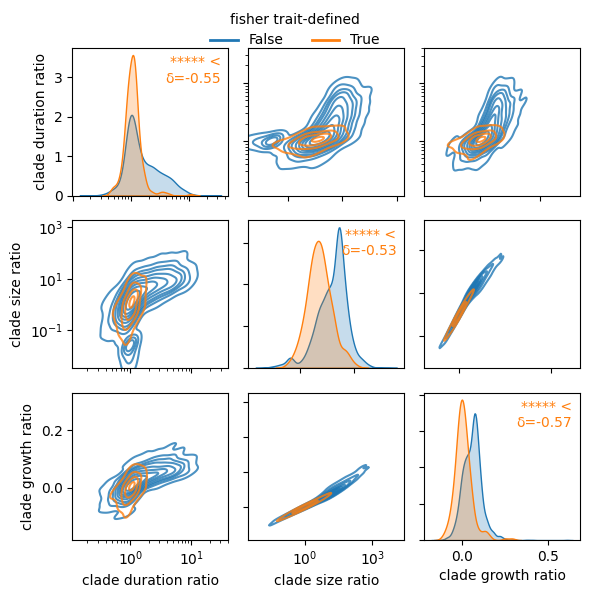

2025-04-07-dev-variantscreen/hue=naive-trait-defined+viz=pairplot+what=trait-defining-sister-stats+ext=.pdf
2025-04-07-dev-variantscreen/hue=naive-trait-defined+viz=pairplot+what=trait-defining-sister-stats+ext=.png


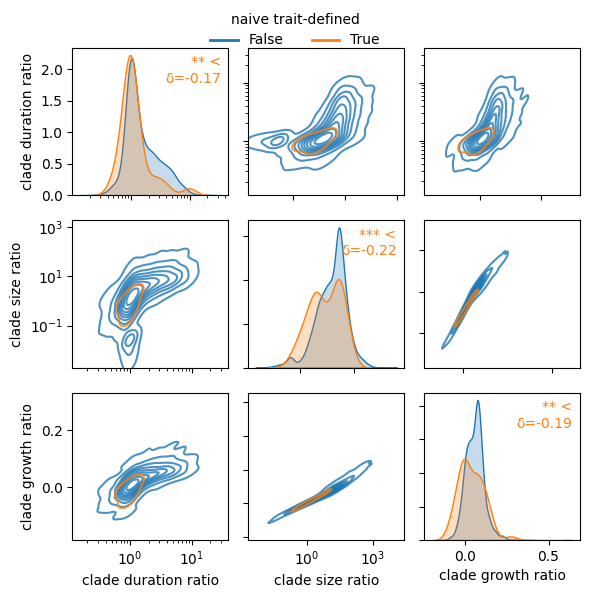

In [20]:
for screen_trait_defined in "fisher trait-defined", "naive trait-defined":
    tp.tee(
        pairplot,
        data_df,
        hue=screen_trait_defined,
        vars_to_plot=[
            "clade duration ratio",
            "clade size ratio",
            "clade growth ratio",
        ],
        log_vars=["clade duration ratio", "clade size ratio"],
        teeplot_outattrs={"what": "trait-defining-sister-stats"},
        teeplot_outdir=teeplot_subdir,
    )
